In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import os

sns.set_theme(font_scale=1.5)

N = 7500

benchmarks_dir = './benchmarks'
benchmarks = [os.path.join(benchmarks_dir, filepath) for filepath in os.listdir(benchmarks_dir) if filepath.endswith('.csv')]

cuda_benchmarks = [filepath for filepath in benchmarks if not ('results-seq' in filepath)]
seq_benchmarks = [filepath for filepath in benchmarks if 'results-seq' in filepath]

def load_df(filepaths: list[str], label: str):
    df = pd.DataFrame()
    print(f"Benchmarks ({label}):")
    for filepath in filepaths:
        print(f"- {os.path.relpath(filepath, benchmarks_dir)}")

        df_local = pd.read_csv(filepath)
        if df.empty:
            df = df_local
        else:
            df = pd.merge(df, df_local, how='outer')
    df = df[df['n'] == N]
    return df

In [2]:
df_seq = load_df(seq_benchmarks, 'SEQUENCIAL')
df_seq = df_seq[df_seq['status'] == 'OK']
df_seq = df_seq[['n', 'run', 'result', 'times']]

display(df_seq.head())

Benchmarks (SEQUENCIAL):
- results-seq-n7500-t7-20251128-200501.csv


,n,run,result,times
0,7500,1,365.953661,7
1,7500,2,369.262856,7
2,7500,3,365.683803,7
3,7500,4,366.005521,7
4,7500,5,369.483934,7


In [ ]:
df_cuda = load_df(cuda_benchmarks, 'CUDA')
df_cuda = df_cuda[df_cuda['status'] == 'OK']
df_cuda = df_cuda[['n', 'bsmode', 'blocks', 'threads', 'max_threads_per_block', 'max_threads_per_sm', 'max_blocks_per_sm', 'clock_mhz', 'sm_count', 'warp_size', 'run', 'result']]
df_cuda = df_cuda.groupby(['n', 'bsmode', 'blocks', 'threads']).agg(
    mean=('result', 'mean'),
    median=('result', 'median'),
    max=('result', 'max'),
    min=('result', 'min'),
    std=('result', 'std'),
    count=('run', 'count'),
    max_threads_per_block=('max_threads_per_block', 'first'),
    max_threads_per_sm=('max_threads_per_sm', 'first'),
    max_blocks_per_sm=('max_blocks_per_sm', 'first'),
    clock_mhz=('clock_mhz', 'first'),
    sm_count=('sm_count', 'first'),
    warp_size=('warp_size', 'first')
).reset_index()
df_cuda['max_threads_per_block'] = df_cuda['max_threads_per_block'].astype(int)
df_cuda['max_threads_per_sm'] = df_cuda['max_threads_per_sm'].astype(int)
df_cuda['sm_count'] = df_cuda['sm_count'].astype(int)
df_cuda['warp_size'] = df_cuda['warp_size'].astype(int)
df_cuda.sort_values(by='blocks', inplace=True)

# Calcular speedup
t_seq_median = df_seq['result'].median()
df_cuda['speedup'] = t_seq_median / df_cuda['median']

display(df_cuda)

print("Blocos x Threads:")
with pd.option_context('display.max_colwidth', None):
    def list_threads(values):
        result = list(set(values))
        result.sort()
        return result
    
    display(
        df_cuda.groupby(by=['n', 'blocks']).agg(
            threads=("threads", list_threads)
        ).sort_values(['n', 'blocks']).reset_index()[['n', 'blocks', 'threads']]
    )


Benchmarks (CUDA):
- results-n7500-t7-20251128-162651.csv
- results-n7500-t7-20251201-132117.csv
- results-n7500-t7-20251201-154147.csv
- results-n7500-t7-20251201-155127.csv
- results-n7500-t7-20251201-041232.csv
- results-n7500-t7-20251201-022436.csv


,n,bsmode,blocks,threads,mean,median,max,min,std,count,max_threads_per_block,max_threads_per_sm,max_blocks_per_sm,clock_mhz,sm_count,warp_size,speedup
36,7500,host,2,32,747.510083,747.504794,747.539172,747.484954,0.021889,7,1024,1024,16,1785,22,32,0.489636
37,7500,host,2,64,384.279739,384.280038,384.300544,384.263159,0.011416,7,1024,1024,16,1785,22,32,0.952445
40,7500,host,2,512,74.404438,74.405373,74.427948,74.387456,0.011359,14,1024,1024,16,1785,22,32,4.919074
41,7500,host,2,1024,66.955899,66.954557,66.971791,66.943563,0.009695,7,1024,1024,16,1785,22,32,5.466477
38,7500,host,2,128,203.178409,203.177207,203.189145,203.166730,0.008967,7,1024,1024,16,1785,22,32,1.801410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,7500,host,11264,64,16.057062,16.057037,16.059154,16.054517,0.001645,7,1024,1024,16,1785,22,32,22.794088
140,7500,host,11264,128,15.084604,15.085378,15.086572,15.081954,0.001868,7,1024,1024,16,1785,22,32,24.262270
141,7500,host,11264,256,14.771868,14.771902,14.775202,14.768184,0.002228,7,1024,1024,16,1785,22,32,24.777143
142,7500,host,11264,512,14.689366,14.688039,14.694422,14.686619,0.002961,7,1024,1024,16,1785,22,32,24.918610


Configurações:


,n,blocks,threads
0,7500,2,"[32, 64, 128, 256, 512, 1024]"
1,7500,4,"[32, 64, 128, 256, 512, 1024]"
2,7500,8,"[32, 64, 128, 256, 512, 1024]"
3,7500,11,"[32, 64, 128, 256, 512, 1024]"
4,7500,16,"[32, 64, 128, 256, 512, 1024]"
5,7500,22,"[32, 64, 128, 256, 512, 1024]"
6,7500,32,"[32, 64, 128, 256, 512, 1024]"
7,7500,44,"[32, 64, 128, 256, 512, 1024]"
8,7500,88,"[32, 64, 128, 256, 512, 1024]"
9,7500,176,"[32, 64, 128, 256, 512, 1024]"


In [4]:
def display_format(df: pd.DataFrame):
    display(df.style.background_gradient(subset=['median'], cmap='Greens_r') \
        .format({'median': '{:.6f} s', 'std': '{:.6f}'}))

df_cuda_top10 = df_cuda.sort_values(by='median', ascending=True).head(10).reset_index(drop=True)
df_cuda_top10['rank'] = df_cuda_top10.index + 1


print(f"=== TOP 10 MELHORES CONFIGURAÇÕES (N={N}) ===")
display_format(df_cuda_top10)

print("Configurações no Top 10:")
print("- blocks:", df_cuda_top10['blocks'].sort_values().unique().tolist())
print("- threads:", df_cuda_top10['threads'].sort_values().unique().tolist())

print("\n" + "-" * 50 + "\n")

print("Melhor configuração:")
display_format(df_cuda_top10[:1])

=== TOP 10 MELHORES CONFIGURAÇÕES (N=7500) ===


,n,bsmode,blocks,threads,mean,median,max,min,std,count,max_threads_per_block,max_threads_per_sm,max_blocks_per_sm,clock_mhz,sm_count,warp_size,speedup,rank
0,7500,host,704,512,14.666408,14.658889 s,14.708478,14.655551,0.018850,7,1024,1024,16,1785,22,32,24.968162,1
1,7500,host,352,512,14.664783,14.663563 s,14.669699,14.660364,0.003219,7,1024,1024,16,1785,22,32,24.960204,2
2,7500,host,176,512,14.665706,14.664986 s,14.670632,14.662829,0.003003,7,1024,1024,16,1785,22,32,24.957782,3
3,7500,host,1408,512,14.670356,14.666622 s,14.690562,14.664032,0.009146,7,1024,1024,16,1785,22,32,24.954998,4
4,7500,host,2816,512,14.671748,14.672278 s,14.675063,14.669080,0.002155,7,1024,1024,16,1785,22,32,24.945378,5
5,7500,host,5632,512,14.687085,14.687572 s,14.691196,14.683576,0.002836,7,1024,1024,16,1785,22,32,24.919403,6
6,7500,host,11264,512,14.689366,14.688039 s,14.694422,14.686619,0.002961,7,1024,1024,16,1785,22,32,24.918610,7
7,7500,host,88,512,14.690879,14.690559 s,14.693358,14.688357,0.001909,7,1024,1024,16,1785,22,32,24.914336,8
8,7500,host,616,512,14.709127,14.709095 s,14.710522,14.707824,0.000956,7,1024,1024,16,1785,22,32,24.882940,9
9,7500,host,814,512,14.741677,14.740821 s,14.746175,14.737220,0.003040,7,1024,1024,16,1785,22,32,24.829385,10


Configurações no Top 10:
- blocks: [88, 176, 352, 616, 704, 814, 1408, 2816, 5632, 11264]
- threads: [512]

--------------------------------------------------

Melhor configuração:


,n,bsmode,blocks,threads,mean,median,max,min,std,count,max_threads_per_block,max_threads_per_sm,max_blocks_per_sm,clock_mhz,sm_count,warp_size,speedup,rank
0,7500,host,704,512,14.666408,14.658889 s,14.708478,14.655551,0.018850,7,1024,1024,16,1785,22,32,24.968162,1


In [16]:
df_cuda_min = df_cuda.sort_values(by='min', ascending=True)[:1]
df_cuda_max = df_cuda.sort_values(by='max', ascending=False)[:1]

print("Execução mais rápida:")
display_format(df_cuda_min)

print("Execução mais lenta:")
display_format(df_cuda_max)

Execução mais rápida:


,n,bsmode,blocks,threads,mean,median,max,min,std,count,max_threads_per_block,max_threads_per_sm,max_blocks_per_sm,clock_mhz,sm_count,warp_size,speedup
112,7500,host,704,512,14.666408,14.658889 s,14.708478,14.655551,0.018850,7,1024,1024,16,1785,22,32,24.968162


Execução mais lenta:


,n,bsmode,blocks,threads,mean,median,max,min,std,count,max_threads_per_block,max_threads_per_sm,max_blocks_per_sm,clock_mhz,sm_count,warp_size,speedup
36,7500,host,2,32,747.510083,747.504794 s,747.539172,747.484954,0.021889,7,1024,1024,16,1785,22,32,0.489636


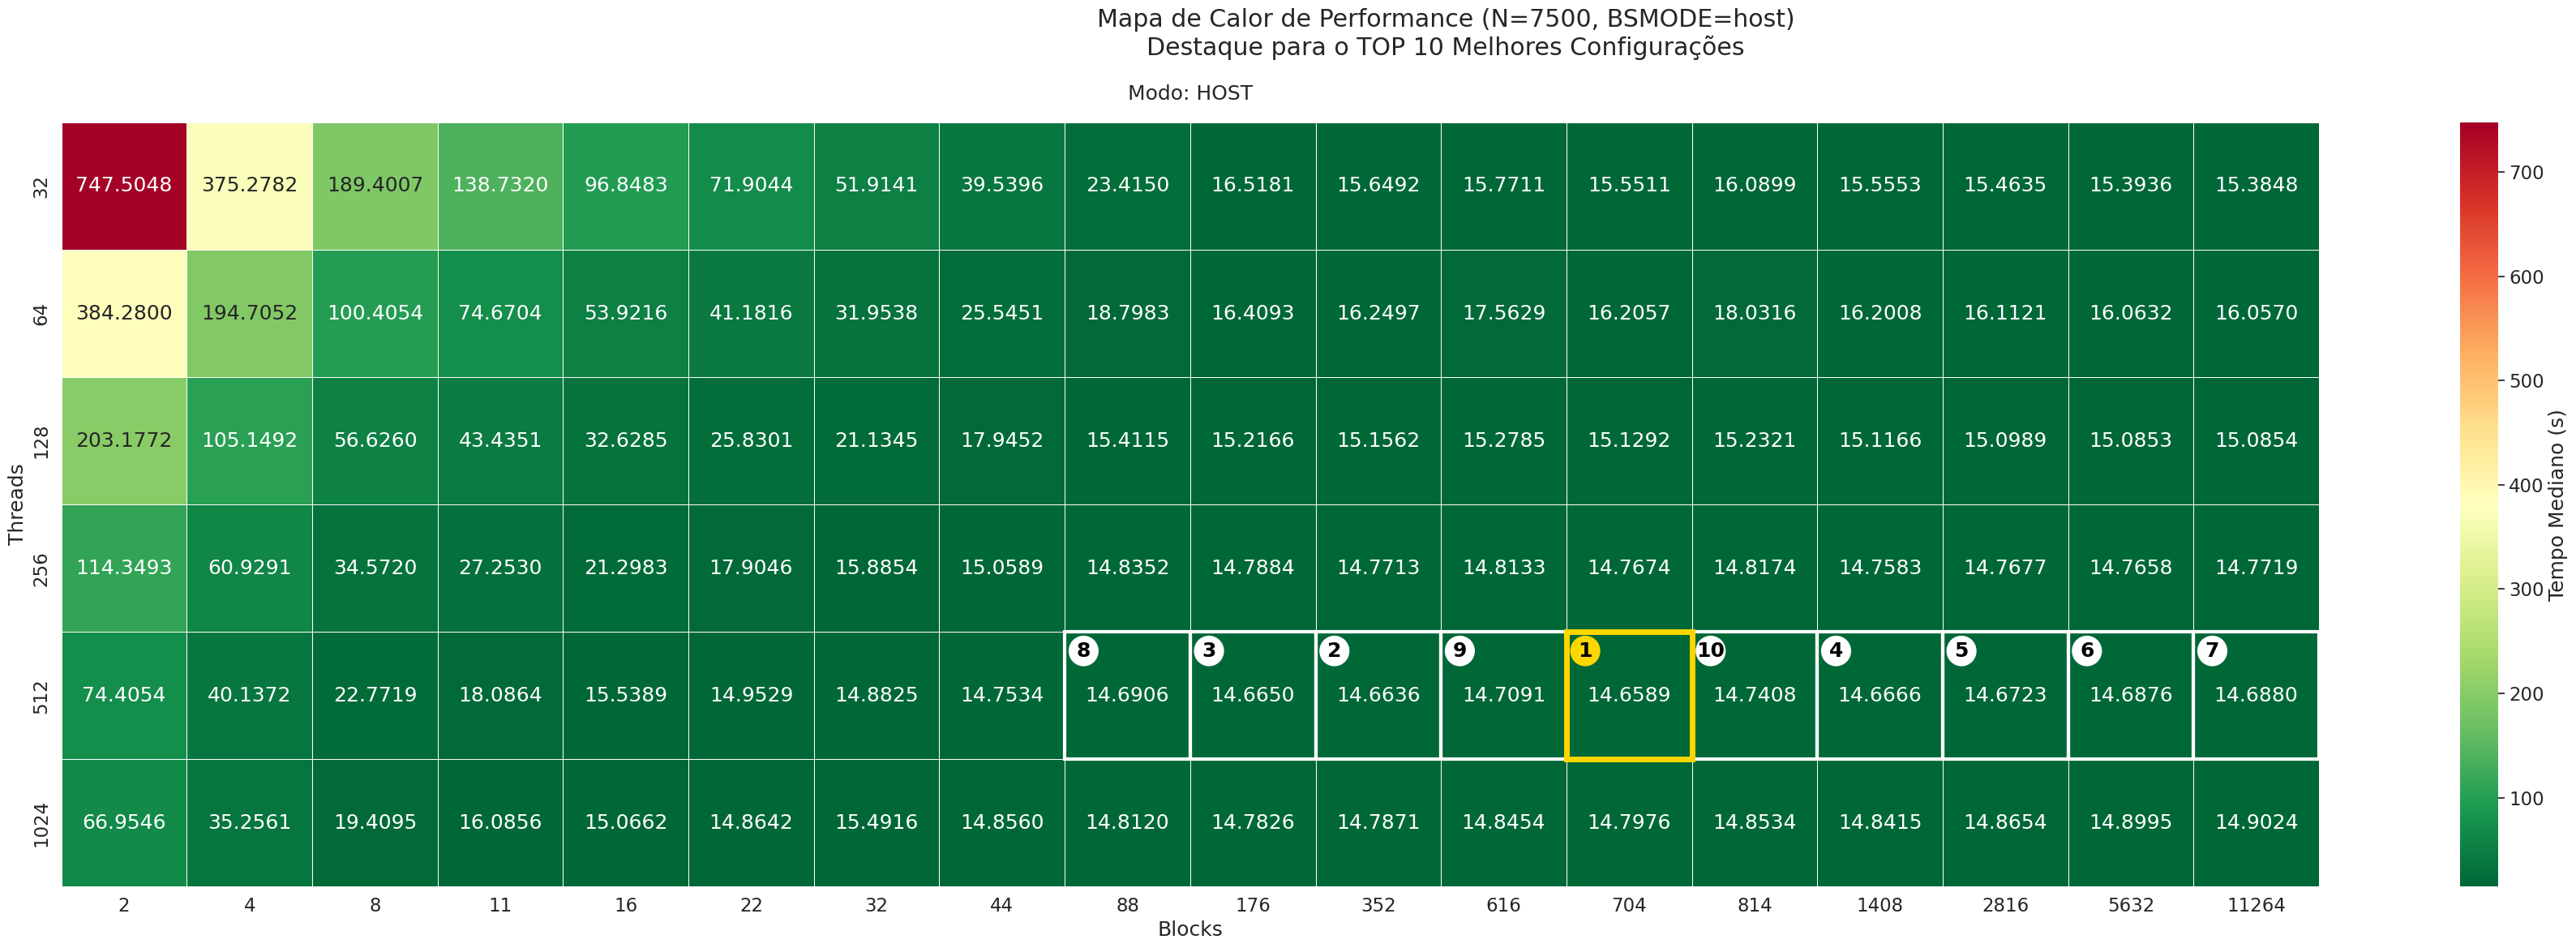

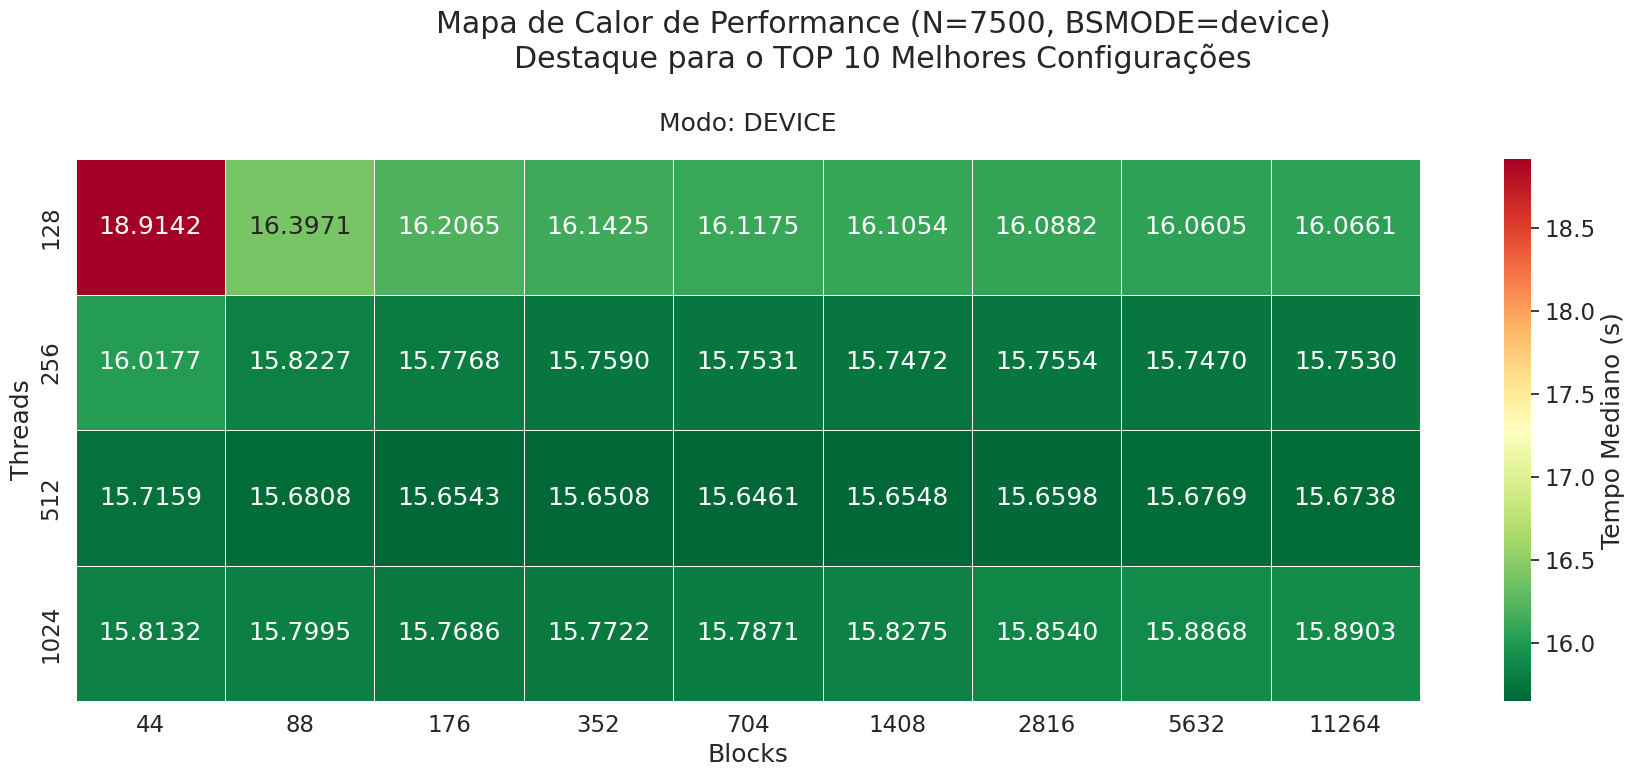

In [6]:
modes = ['host', 'device'] # Ordem dos plots

for i, mode in enumerate(modes):
    subset = df_cuda[df_cuda['bsmode'] == mode]

    rows = len(subset['threads'].unique().tolist())
    cols = len(subset['blocks'].unique().tolist())

    fig = plt.figure(figsize=(cols*2, rows*2))
    fig.suptitle(f'Mapa de Calor de Performance (N={N}, BSMODE={mode})\nDestaque para o TOP 10 Melhores Configurações')
    
    pivot_median = subset.pivot(index='threads', columns='blocks', values='median')

    if pivot_median.empty:
        continue
    
    # Desenhar o Heatmap base
    ax = sns.heatmap(pivot_median, annot=True, fmt=".4f", cmap='RdYlGn_r',
                linewidths=.5, cbar_kws={'label': 'Tempo Mediano (s)'})
    
    ax.set_title(f'Modo: {mode.upper()}', pad=20)
    ax.set_xlabel('Blocks')
    ax.set_ylabel('Threads')

    top_in_mode = df_cuda_top10[df_cuda_top10['bsmode'] == mode]
    
    for _, row in top_in_mode[::-1].iterrows():
        rank = int(row['rank'])
        b_mult = row['blocks']
        t_fact = row['threads']
        
        # Encontrar as coordenadas X, Y no grid do Heatmap
        # O eixo X são as colunas (blocks)
        # O eixo Y são os índices (threads)
        try:
            col_idx = pivot_median.columns.get_loc(b_mult)
            row_idx = pivot_median.index.get_loc(t_fact)
            
            # Definir cor do destaque: Ouro para #1, Azul Ciano para os outros
            edge_color = '#FFD700' if rank == 1 else '#fff'
            line_width = 5 if rank == 1 else 3
            
            # 1. Desenhar o Retângulo
            rect = patches.Rectangle((col_idx, row_idx), 1, 1, 
                                    linewidth=line_width, edgecolor=edge_color, facecolor='none')
            ax.add_patch(rect)
            
            # 2. Adicionar o Número do Rank (badge) no canto
            # Criar um pequeno círculo de fundo para o número ficar legível
            circle = patches.Circle((col_idx + 0.15, row_idx + 0.15), 0.12, 
                                    facecolor=edge_color, edgecolor='none', zorder=10)
            ax.add_patch(circle)
            
            # Texto do número
            ax.text(col_idx + 0.15, row_idx + 0.15, str(rank), 
                    color='black', ha='center', va='center', 
                    fontweight='bold', zorder=11)
            
        except KeyError:
            # Caso a combinação não esteja no pivot (não deve acontecer se filtrado certo)
            pass

    plt.tight_layout()
    plt.show()

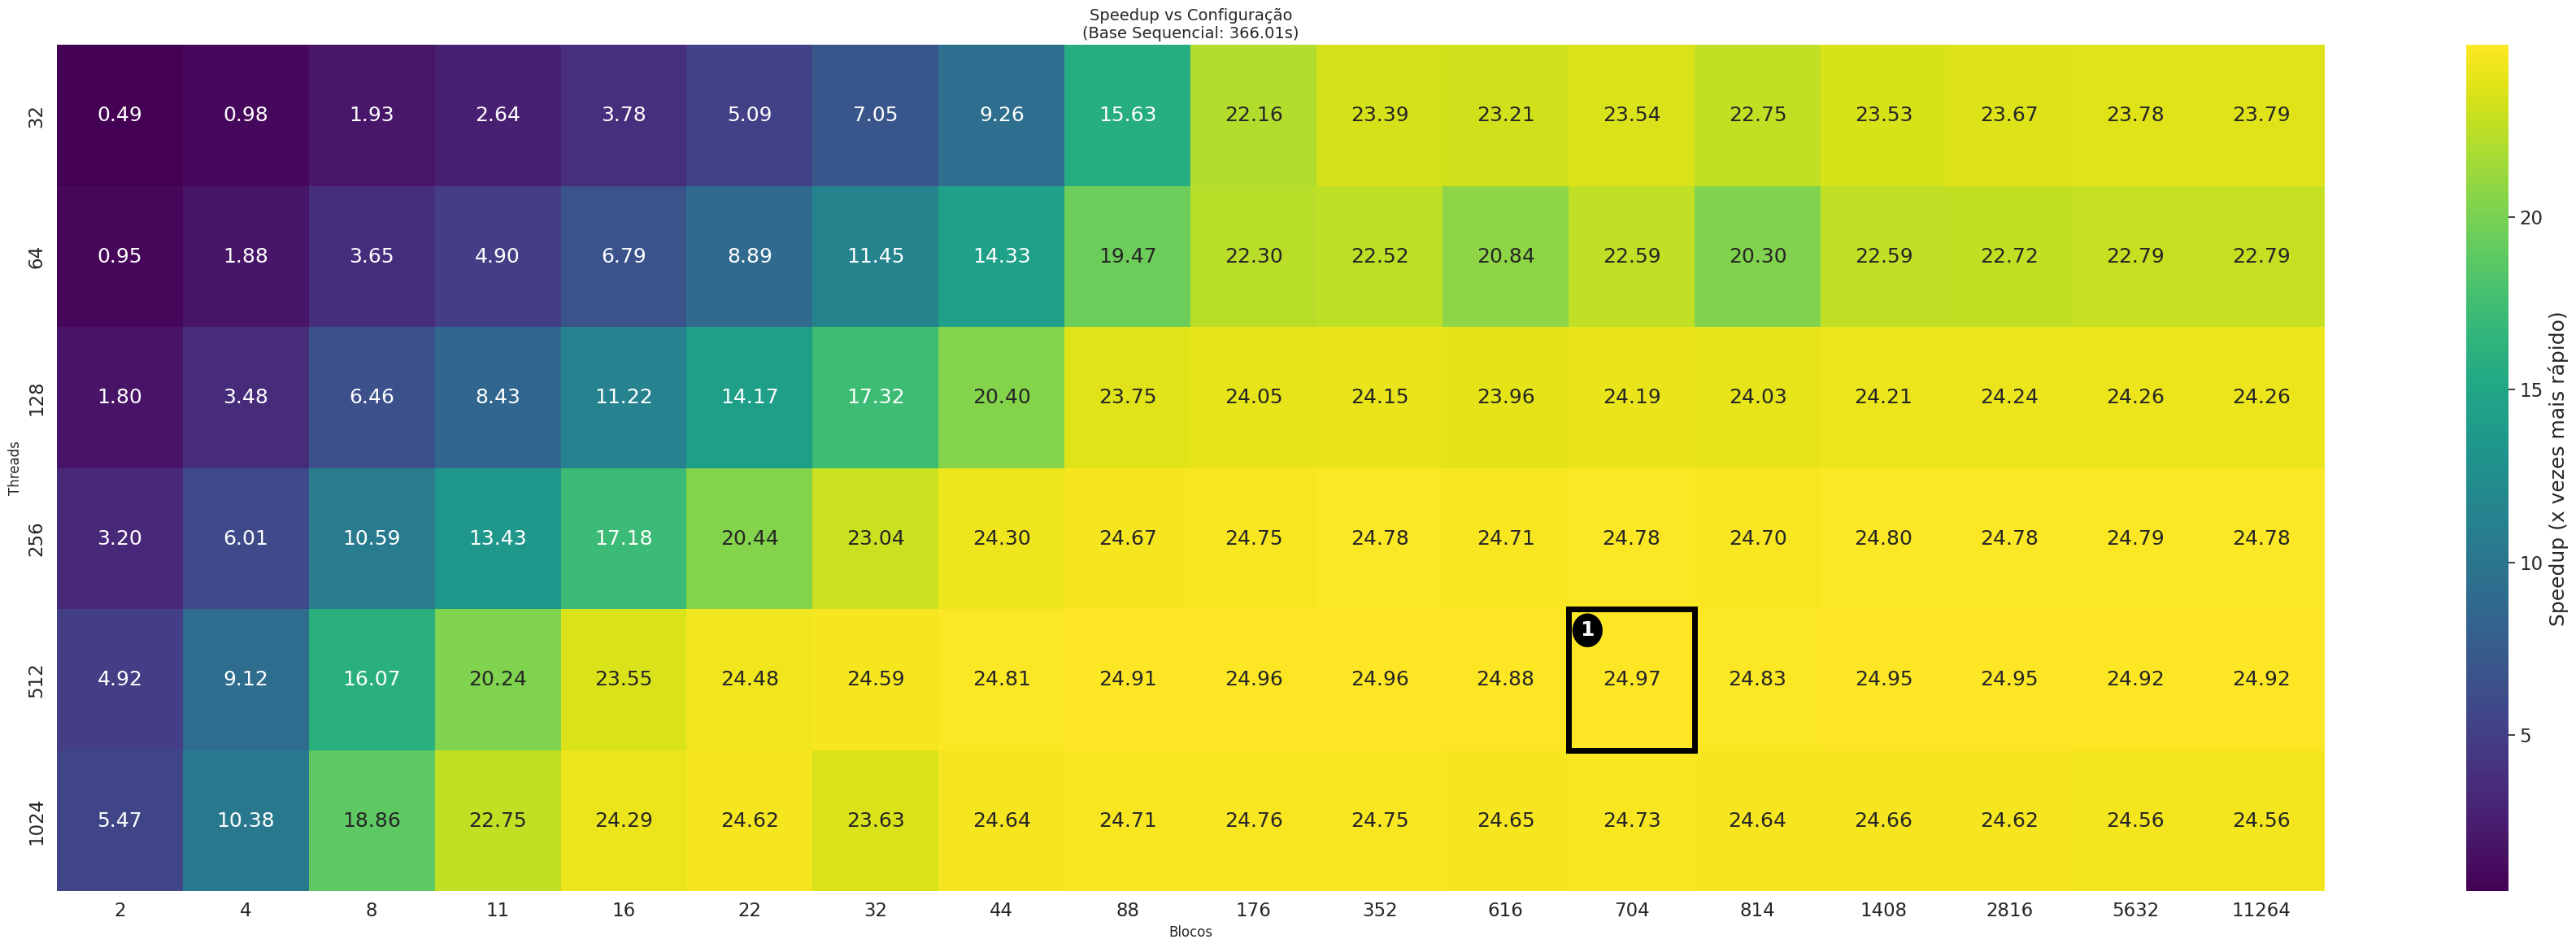

In [ ]:
# Criar a matriz para o heatmap
df_cuda_host = df_cuda[df_cuda['bsmode'] == 'host']

pivot_table = df_cuda_host.pivot(index='threads', columns='blocks', values='speedup')

cols = len(df_cuda_host['blocks'].unique().tolist())
rows = len(df_cuda_host['threads'].unique().tolist())
plt.figure(figsize=(cols*2, rows*2))

# Desenhar Heatmap
ax = sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis', 
            cbar_kws={'label': 'Speedup (x vezes mais rápido)'})

plt.title(f'Speedup vs Configuração\n(Base Sequencial: {t_seq_median:.2f}s)', fontsize=14)
plt.xlabel('Blocos', fontsize=12)
plt.ylabel('Threads', fontsize=12)

# Destacar o melhor valor
max_val_idx = df_cuda_host['speedup'].idxmax()

col_idx = pivot_table.columns.get_loc(df_cuda_host.loc[max_val_idx]['blocks'])
row_idx = pivot_table.index.get_loc(df_cuda_host.loc[max_val_idx]['threads'])

# Definir cor do destaque: Ouro para #1, Azul Ciano para os outros
edge_color = 'black'

# 1. Desenhar o Retângulo
rect = patches.Rectangle((col_idx, row_idx), 1, 1, 
                        linewidth=5, edgecolor=edge_color, facecolor='none')
ax.add_patch(rect)

# 2. Adicionar o Número do Rank (badge) no canto
# Criar um pequeno círculo de fundo para o número ficar legível
circle = patches.Circle((col_idx + 0.15, row_idx + 0.15), 0.12, 
                        facecolor=edge_color, edgecolor='none', zorder=10)
ax.add_patch(circle)

# Texto do número
ax.text(col_idx + 0.15, row_idx + 0.15, str(rank), 
        color='white', ha='center', va='center',
        fontweight='bold', zorder=11)

plt.tight_layout()
plt.show()

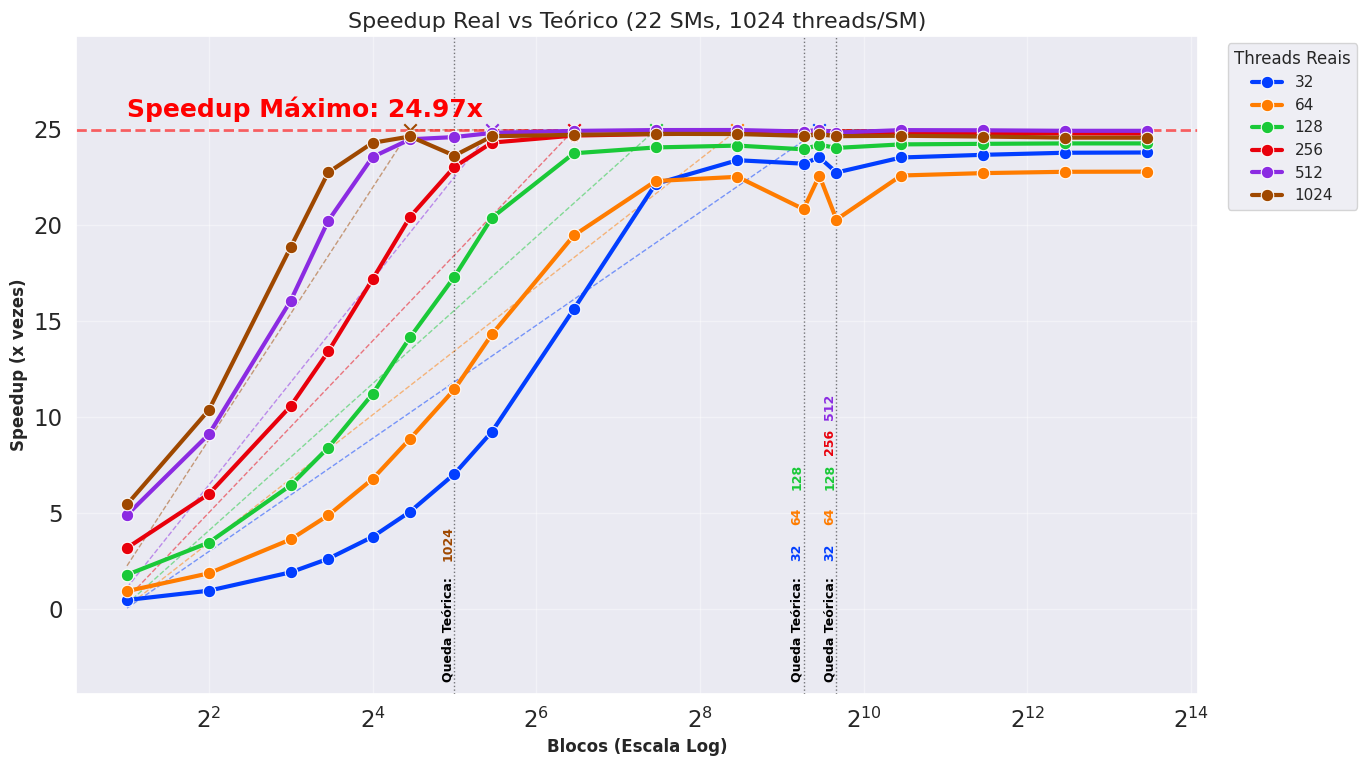

In [30]:
# Função mantida
def calculate_expected_drops(blocks: list[int], threads: int, sm_count: int, max_blocks_per_sm: int, max_threads_per_sm: int):
    # Capacidade simultânea total da GPU (Onda Cheia)
    real_blocks_per_sm = min(max_blocks_per_sm, int(max_threads_per_sm / threads))
    gpu_total_capacity = sm_count * real_blocks_per_sm
    
    drops = []
    for b in blocks:
        if b > gpu_total_capacity and (b % gpu_total_capacity) != 0:
            drops.append(b)
    return drops

# Configuração dos dados
df_cuda_subset = df_cuda_host.copy()
unique_threads = sorted(df_cuda_subset['threads'].unique())
colors = sns.color_palette('bright', len(unique_threads))

# Mapa de cores para facilitar o acesso posterior
thread_color_map = {t: colors[i] for i, t in enumerate(unique_threads)}

# Extração de parâmetros de Hardware
sm_count = df_cuda_subset['sm_count'].iloc[0]
max_threads_per_sm = df_cuda_subset['max_threads_per_sm'].iloc[0]
max_blocks_per_sm = df_cuda_subset['max_blocks_per_sm'].iloc[0]

plt.figure(figsize=(14, 8))

# 1. Plotar as Linhas Reais
sns.lineplot(data=df_cuda_subset, x='blocks', y='speedup', 
             hue='threads', palette=colors, 
             marker='o', linewidth=3, markersize=9, zorder=5)

# 2. Plotar Linhas Teóricas
max_observed_speedup = df_cuda_subset['speedup'].max()
drops_aggregated = {} # Dicionário para agrupar: {bloco: [lista_threads]}

for i, t in enumerate(unique_threads):
    saturation_blocks = (sm_count * max_threads_per_sm) / t
    slope = max_observed_speedup / saturation_blocks
    
    x_vals = [df_cuda_subset['blocks'].min(), saturation_blocks, df_cuda_subset['blocks'].max()]
    y_vals = [slope * x if x < saturation_blocks else max_observed_speedup for x in x_vals]
            
    # Linha pontilhada teórica
    plt.plot(x_vals, y_vals, color=colors[i], linestyle='--', alpha=0.5, linewidth=1)
    
    # Marcador de saturação
    if df_cuda_subset['blocks'].min() <= saturation_blocks <= df_cuda_subset['blocks'].max():
        plt.scatter([saturation_blocks], [max_observed_speedup], color=colors[i], marker='x', s=80, zorder=4)

    # --- CÁLCULO DOS DROPS (apenas armazena, não plota ainda) ---
    thread_blocks = df_cuda_subset[df_cuda_subset['threads'] == t]['blocks'].unique().tolist()
    current_drops = calculate_expected_drops(thread_blocks, t, sm_count, max_blocks_per_sm, max_threads_per_sm)
    
    for dp in current_drops:
        if dp not in drops_aggregated:
            drops_aggregated[dp] = []
        drops_aggregated[dp].append(t)

# 3. Plotagem Agrupada dos Drops (Linha Preta + Texto Colorido)
# Calcula limites para posicionamento do texto
y_min_vis = df_cuda_subset['speedup'].min()
y_max_vis = df_cuda_subset['speedup'].max()
text_step = (y_max_vis - y_min_vis) * 0.05 # Passo vertical entre os números

for block_point, threads_list in drops_aggregated.items():
    # Linha vertical preta única
    plt.axvline(x=block_point, color='black', linestyle=':', alpha=0.5, linewidth=1, zorder=3)
    
    # Texto base "Drops"
    base_y = y_min_vis - (text_step * 3.5) # Começa um pouco abaixo
    plt.text(block_point, base_y, "Queda Teórica:", color='black', fontsize=9, rotation=90, ha='right', va='bottom', fontweight='bold')
    
    # Empilha os números das threads
    # Ordenamos a lista para ficar bonito visualmente (menor thread embaixo)
    for idx, t in enumerate(sorted(threads_list)):
        current_y = base_y + 4.5 + ((idx + 1) * text_step * 1.5) # Espaçamento vertical
        # Plota apenas o número, com a cor correspondente
        plt.text(block_point, current_y, str(t), 
                 color=thread_color_map[t], fontsize=9, fontweight='bold', 
                 rotation=90, ha='right', va='bottom', zorder=6)


# 4. Ajustes Finais e Teto
plt.axhline(y=max_observed_speedup, color='red', linestyle='--', alpha=0.6, linewidth=2)
plt.text(df_cuda_subset['blocks'].min(), max_observed_speedup + 0.4, 
         f'Speedup Máximo: {max_observed_speedup:.2f}x', 
         color='red', va='bottom', fontweight='bold')

plt.xscale('log', base=2)
plt.grid(True, which="major", ls="-", alpha=0.4)
plt.grid(True, which="minor", ls=":", alpha=0.2)

plt.title(f'Speedup Real vs Teórico ({sm_count} SMs, {max_threads_per_sm} threads/SM)', fontsize=16)
plt.xlabel('Blocos (Escala Log)', fontsize=12, fontweight='bold')
plt.ylabel('Speedup (x vezes)', fontsize=12, fontweight='bold')

plt.legend(title='Threads Reais', title_fontsize='12', fontsize='11', 
           bbox_to_anchor=(1.02, 1), loc='upper left')

margin = (y_max_vis - y_min_vis) * 0.2
plt.ylim(bottom=y_min_vis - margin, top=y_max_vis + margin)

plt.tight_layout()
plt.show()